# Classification Workflow: Pipelines!

## Objectives

- Formulate and implement an iterative modeling workflow
- Recognize how pipelines streamline the preprocessing and modeling process

## Why Pipeline?

Pipelines can keep our code neat and clean all the way from gathering & cleaning our data, to creating models & fine-tuning them!

**Advantages**: 
- Reduces complexity
- Convenient 
- Flexible 
- Can help prevent mistakes (like data leakage between train and test set) 

## Today's Agenda: 

We'll introduce pipelines in the lens of simplifying the whole classification workflow, top to bottom!

Our data: https://www.kaggle.com/c/cat-in-the-dat-ii

The goal is to classify the `target` column. 

The competition's main metric is ROC-AUC score! We can explore other metrics, but we should be sure to use that to evaluate our models.

### Steps:

1. Data Exploration
2. Define and structure data preprocessing steps
3. Run a `DummyClassifier` to create a model-less baseline, using a pipeline to combine the classifier with preprocessing steps
4. Run a `LogisticRegression` and compare results to the model-less baseline

If we have time, we'll keep iterating to improve!

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
# Grab, then explore data
df = pd.read_csv("data/cat_in_the_dat2_train.csv", index_col='id')

In [3]:
# Define our X and y

X = df.drop(columns=['target'])
y = df['target']

# and train test split - to create our val holdout set!
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,
                                                  random_state=0)

## Data Exploration

Explore the **training** data, checking out both numeric and categorical features.

We should run _at least_ one visualization to explore relationships among features!

In [4]:
# Your code here
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540000 entries, 111903 to 305711
Data columns (total 23 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   523875 non-null  float64
 1   bin_1   523788 non-null  float64
 2   bin_2   523842 non-null  float64
 3   bin_3   523821 non-null  object 
 4   bin_4   523757 non-null  object 
 5   nom_0   523586 non-null  object 
 6   nom_1   523710 non-null  object 
 7   nom_2   523725 non-null  object 
 8   nom_3   523642 non-null  object 
 9   nom_4   523754 non-null  object 
 10  nom_5   524031 non-null  object 
 11  nom_6   523727 non-null  object 
 12  nom_7   523823 non-null  object 
 13  nom_8   524017 non-null  object 
 14  nom_9   523725 non-null  object 
 15  ord_0   523528 non-null  float64
 16  ord_1   523778 non-null  object 
 17  ord_2   523694 non-null  object 
 18  ord_3   523891 non-null  object 
 19  ord_4   523867 non-null  object 
 20  ord_5   524095 non-null  object 
 21  day  

In [5]:
X_train.head(3)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
111903,0.0,0.0,0.0,F,NaN,Red,Polygon,Lion,Finland,Bassoon,...,9dd6a02eb,6ce8fe5ee,3.0,Novice,Warm,c,O,NS,4.0,9.0
521435,0.0,1.0,0.0,F,N,Red,Triangle,Axolotl,Finland,Bassoon,...,679b63eff,a737a6428,2.0,Grandmaster,Freezing,m,A,gc,5.0,1.0
484488,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,India,Theremin,...,fbea9bb4a,b787c48f0,2.0,Master,Freezing,k,I,rl,2.0,8.0


In [6]:
X_train.describe()

,bin_0,bin_1,bin_2,ord_0,day,month
count,523875.000000,523788.000000,523842.000000,523528.000000,523850.000000,523817.000000
mean,0.092245,0.185692,0.278842,1.947663,4.112578,6.372836
std,0.289372,0.388858,0.448430,0.853963,2.034344,3.459506
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,3.000000
50%,0.000000,0.000000,0.000000,2.000000,5.000000,6.000000
75%,0.000000,0.000000,1.000000,3.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,3.000000,7.000000,12.000000


In [8]:
X_train.dropna()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,
521435,0.0,1.0,0.0,F,N,Red,Triangle,Axolotl,Finland,Bassoon,...,679b63eff,a737a6428,2.0,Grandmaster,Freezing,m,A,gc,5.0,1.0
484488,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,India,Theremin,...,fbea9bb4a,b787c48f0,2.0,Master,Freezing,k,I,rl,2.0,8.0
112613,0.0,0.0,0.0,F,Y,Green,Polygon,Axolotl,Costa Rica,Theremin,...,fe070240a,1aaae9c6f,3.0,Expert,Boiling Hot,m,X,Pk,3.0,4.0
549585,0.0,1.0,1.0,F,N,Blue,Polygon,Dog,Costa Rica,Bassoon,...,8109ba950,85e0d24dc,3.0,Grandmaster,Cold,k,Y,WW,7.0,6.0
321528,0.0,0.0,1.0,F,N,Blue,Triangle,Dog,Costa Rica,Oboe,...,7d7c02c57,1a26e9987,1.0,Contributor,Warm,a,U,ok,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170584,0.0,0.0,0.0,F,N,Red,Trapezoid,Lion,India,Bassoon,...,d1c6bb70d,57cfbaedd,2.0,Expert,Freezing,n,K,ok,3.0,5.0
122579,0.0,0.0,0.0,F,N,Green,Polygon,Hamster,China,Bassoon,...,798ccea46,72b96a851,1.0,Novice,Boiling Hot,c,Q,yK,2.0,7.0
152315,0.0,0.0,0.0,F,Y,Red,Triangle,Lion,Finland,Bassoon,...,28c042258,38270a265,3.0,Grandmaster,Freezing,n,Q,Pw,1.0,5.0


In [14]:
for col in X_train.columns:
    display(X_train[col].value_counts)
    print("*"*20)

<bound method IndexOpsMixin.value_counts of id
111903    0.0
521435    0.0
484488    0.0
529639    0.0
589943    0.0
         ... 
359783    0.0
152315    0.0
117952    NaN
435829    1.0
305711    0.0
Name: bin_0, Length: 540000, dtype: float64>

********************


<bound method IndexOpsMixin.value_counts of id
111903    0.0
521435    1.0
484488    0.0
529639    1.0
589943    NaN
         ... 
359783    0.0
152315    0.0
117952    1.0
435829    1.0
305711    0.0
Name: bin_1, Length: 540000, dtype: float64>

********************


<bound method IndexOpsMixin.value_counts of id
111903    0.0
521435    0.0
484488    0.0
529639    1.0
589943    0.0
         ... 
359783    1.0
152315    0.0
117952    0.0
435829    1.0
305711    1.0
Name: bin_2, Length: 540000, dtype: float64>

********************


<bound method IndexOpsMixin.value_counts of id
111903    F
521435    F
484488    F
529639    F
589943    T
         ..
359783    F
152315    F
117952    T
435829    T
305711    T
Name: bin_3, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    NaN
521435      N
484488      N
529639      N
589943      N
         ... 
359783      N
152315      Y
117952      N
435829      N
305711      N
Name: bin_4, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903     Red
521435     Red
484488     Red
529639     Red
589943     Red
          ... 
359783    Blue
152315     Red
117952     Red
435829     Red
305711    Blue
Name: nom_0, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903      Polygon
521435     Triangle
484488    Trapezoid
529639     Triangle
589943     Triangle
            ...    
359783       Circle
152315     Triangle
117952      Polygon
435829     Triangle
305711     Triangle
Name: nom_1, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903       Lion
521435    Axolotl
484488    Hamster
529639    Hamster
589943        Cat
           ...   
359783    Hamster
152315       Lion
117952    Hamster
435829       Lion
305711    Hamster
Name: nom_2, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903       Finland
521435       Finland
484488         India
529639    Costa Rica
589943        Russia
             ...    
359783         India
152315       Finland
117952        Canada
435829    Costa Rica
305711    Costa Rica
Name: nom_3, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903     Bassoon
521435     Bassoon
484488    Theremin
529639     Bassoon
589943       Piano
            ...   
359783     Bassoon
152315     Bassoon
117952     Bassoon
435829    Theremin
305711     Bassoon
Name: nom_4, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    2ceb3c2c2
521435    106ec5883
484488    edc3d5f4b
529639    4a1a59862
589943    b2520fd45
            ...    
359783    5ea48fdbd
152315    20fb9faab
117952    094b85efd
435829    c8fb0fd36
305711    29ede9e9b
Name: nom_5, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    8a2420f6a
521435    289755dc2
484488    58137fe64
529639          NaN
589943    89545cc37
            ...    
359783    549b11326
152315    8f065bc17
117952    a0d8dd788
435829    79288f5e8
305711    d78b1df07
Name: nom_6, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    4ae48e857
521435    c79d2197d
484488    bc9cc2a94
529639    00a7f9a05
589943    2c4f9614e
            ...    
359783    4ae48e857
152315    909943002
117952    3efdc7987
435829    56d35c774
305711    41901460a
Name: nom_7, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    9dd6a02eb
521435    679b63eff
484488    fbea9bb4a
529639    b72c0bbc2
589943    b8e63cace
            ...    
359783          NaN
152315    28c042258
117952    60c7c84ee
435829    1ce5cf721
305711    53efabb84
Name: nom_8, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    6ce8fe5ee
521435    a737a6428
484488    b787c48f0
529639          NaN
589943    10695338e
            ...    
359783    a71bc91ae
152315    38270a265
117952    6b55f99bc
435829    9979d91fc
305711    1ebe4a323
Name: nom_9, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    3.0
521435    2.0
484488    2.0
529639    1.0
589943    2.0
         ... 
359783    3.0
152315    3.0
117952    3.0
435829    3.0
305711    2.0
Name: ord_0, Length: 540000, dtype: float64>

********************


<bound method IndexOpsMixin.value_counts of id
111903         Novice
521435    Grandmaster
484488         Master
529639         Expert
589943         Expert
             ...     
359783         Novice
152315    Grandmaster
117952    Grandmaster
435829    Contributor
305711         Novice
Name: ord_1, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903           Warm
521435       Freezing
484488       Freezing
529639            Hot
589943           Warm
             ...     
359783    Boiling Hot
152315       Freezing
117952           Cold
435829           Cold
305711       Lava Hot
Name: ord_2, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903      c
521435      m
484488      k
529639      e
589943      a
         ... 
359783    NaN
152315      n
117952      m
435829      b
305711      h
Name: ord_3, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    O
521435    A
484488    I
529639    P
589943    N
         ..
359783    M
152315    Q
117952    X
435829    O
305711    X
Name: ord_4, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    NS
521435    gc
484488    rl
529639    WW
589943    LY
          ..
359783    iS
152315    Pw
117952    pT
435829    gc
305711    mP
Name: ord_5, Length: 540000, dtype: object>

********************


<bound method IndexOpsMixin.value_counts of id
111903    4.0
521435    5.0
484488    2.0
529639    5.0
589943    6.0
         ... 
359783    3.0
152315    1.0
117952    1.0
435829    5.0
305711    5.0
Name: day, Length: 540000, dtype: float64>

********************


<bound method IndexOpsMixin.value_counts of id
111903     9.0
521435     1.0
484488     8.0
529639     2.0
589943     8.0
          ... 
359783    11.0
152315     5.0
117952     6.0
435829     6.0
305711     7.0
Name: month, Length: 540000, dtype: float64>

********************


In [15]:
X_train.describe(include='O')

,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_1,ord_2,ord_3,ord_4,ord_5
count,523821,523757,523586,523710,523725,523642,523754,524031,523727,523823,524017,523725,523778,523694,523891,523867,524095
unique,2,2,3,6,6,6,4,1220,1519,222,222,2218,5,6,15,26,190
top,F,N,Red,Triangle,Hamster,India,Theremin,423976253,ea8c5e181,c79d2197d,15f03b1f4,8f3276a6e,Novice,Freezing,n,N,Fl
freq,329627,281108,291147,147917,148355,148572,277705,867,728,4537,4518,523,144512,128452,64015,35891,9503


## Data Preprocessing

Let's outline our data processing strategy!

#### Discuss:

Some questions we can ask ourselves:

> How will we handle any null values? How will we handle any categorical features? What if our categorical features have 20+ unique values in each column? How will we scale our features?

- start with simple imputer to fill with all "Unknown"
- categories with >20 uniques: one-hot-encode to make binary
- categories with <20 uniques ...???
    - we could drop those columns
    - we could build indicator
    - we could frequency encode


In [17]:
used_cols = []
for col in X_train.columns:
    if len(X_train[col].unique()) <  30:
        used_cols.append(col)

In [19]:
used_cols

['bin_0',
 'bin_1',
 'bin_2',
 'bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'ord_0',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'day',
 'month']

In [20]:
X_train[used_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540000 entries, 111903 to 305711
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bin_0   523875 non-null  float64
 1   bin_1   523788 non-null  float64
 2   bin_2   523842 non-null  float64
 3   bin_3   523821 non-null  object 
 4   bin_4   523757 non-null  object 
 5   nom_0   523586 non-null  object 
 6   nom_1   523710 non-null  object 
 7   nom_2   523725 non-null  object 
 8   nom_3   523642 non-null  object 
 9   nom_4   523754 non-null  object 
 10  ord_0   523528 non-null  float64
 11  ord_1   523778 non-null  object 
 12  ord_2   523694 non-null  object 
 13  ord_3   523891 non-null  object 
 14  ord_4   523867 non-null  object 
 15  day     523850 non-null  float64
 16  month   523817 non-null  float64
dtypes: float64(6), object(11)
memory usage: 74.2+ MB


Let's build a column transformer to define our data processing steps. Note that it's typically easiest to create list-like arrays of column names to match up with each processing step. Also - don't repeat columns! SKLearn's ColumnTransformer needs the lists of features it's processing to be mutually exclusive.

Reference: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [42]:
# Your code here

binary_objects = ['bin_3', 'bin_4']
nom_objects = [col for col in used_cols if 'nom_' in col]
ord_objects = ['ord_1', 'ord_2', 'ord_3', 'ord_4']

In [43]:
obj_cols = [col for col in used_cols if X_train[col].dtype == 'O']

In [44]:
obj_transformer = Pipeline(steps=[
    ("obj_imputer", SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(drop=['Unknown']*len(obj_cols))),
])

In [45]:
num_cols = [col for col in used_cols if X_train[col].dtype != 'O']

In [46]:
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
])

In [47]:
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_transformer, num_cols),
    ('obj_trans', obj_transformer, obj_cols)
])

In [48]:
preprocessor.fit_transform(X_train)

<540000x87 sparse matrix of type '<class 'numpy.float64'>'
	with 7327930 stored elements in Compressed Sparse Row format>

## Baseline Model

Let's find out how hard our problem is, by creating a model-less baseline!

If we use SKLearn's `DummyClassifier`, we can create our first full Pipeline!

Reference: https://scikit-learn.org/stable/modules/compose.html#pipeline

In [49]:
# Your code here

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modelless_baseline', DummyClassifier(strategy='prior'))
])

In [50]:
clf.fit(X_train, y_train)

train_preds = clf.predict(X_train)

In [51]:
train_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [52]:
cv_results = cross_validate(clf, X_train, y_train, cv=5)

In [55]:
cv_results['test_score']

array([0.81247222, 0.81247222, 0.81247222, 0.81247222, 0.81247222])

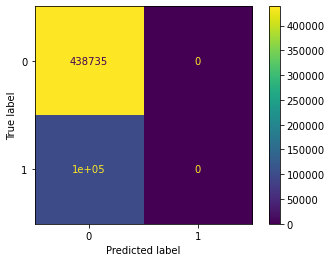

In [56]:
plot_confusion_matrix(clf, X_train, y_train)

#### Evaluate:

- 


## Logistic Regression

Let's build an initial logistic regression model, using the same preprocessing steps:

In [ ]:
# Your code here

In [61]:
lrm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logistic_model', LogisticRegression(random_state=42, max_iter=500))
])

In [62]:
lrm.fit(X_train, y_train)

train_preds2 = lrm.predict(X_train)

In [63]:
train_preds2

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [67]:
cv_results2 = cross_validate(lrm, X_train, y_train, scoring='roc_auc', n_jobs=-1)

In [68]:
cv_results2['test_score']

array([0.73592697, 0.73430216, 0.73870169, 0.73259737, 0.73553261])

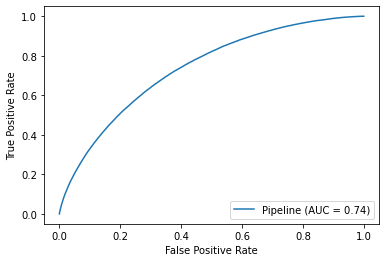

In [69]:
plot_roc_curve(lrm, X_train, y_train)

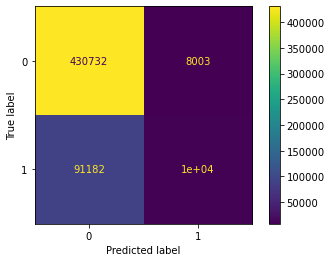

In [70]:
plot_confusion_matrix(lrm, X_train, y_train)

#### Evaluate:

- 


## Iterate

Let's either change something in our preprocessor, change something about our logistic regression model set up, or change the features we're using, then try again.

In [73]:
# Your code here

#### Evaluate:

- 


## Validate

How does our best model (so far) perform on our holdout val set?

In [71]:
# Your code here
val_probs = lrm.predict_proba(X_val)[:,1]

In [72]:
roc_auc_score(y_val, val_probs)

0.7380504131558338

#### Discuss:

- 


## Resources

Check out Aurélien Geron's notebook of an [end-to-end ml project](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on his GitHub repo based around his book [_Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed)_](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)

## Level Up - What to do with too many options in categorical columns?


New library you can install with MORE encoding techniques, beyond one-hot encoding! https://contrib.scikit-learn.org/category_encoders/

- (these work within SKLearn pipelines, since they're written in the SKLearn style!)
